In [3]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [4]:
path = '1661-0.txt'
txt = open(path).read().lower()

In [5]:
print(len(txt))

581888


In [6]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(txt)

In [7]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [8]:
Word_len = 5
previous_words = []
next_words = []
for i in range(len(words) - Word_len):
    previous_words.append(words[i:i + Word_len])
    next_words.append(words[i + Word_len])
print(previous_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [9]:
X = np.zeros((len(previous_words), Word_len, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)

In [10]:
for i, each_words in enumerate(previous_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [11]:
print(X[1][1])

[False False False ... False False False]


In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(Word_len, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [13]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
811/811 [==============================] - 21s 17ms/step - loss: 6.0148 - accuracy: 0.1065 - val_loss: 7.1202 - val_accuracy: 0.0989
Epoch 2/20
811/811 [==============================] - 13s 16ms/step - loss: 5.7683 - accuracy: 0.1472 - val_loss: 7.8909 - val_accuracy: 0.1038
Epoch 3/20
811/811 [==============================] - 13s 17ms/step - loss: 5.7690 - accuracy: 0.1738 - val_loss: 7.9551 - val_accuracy: 0.1027
Epoch 4/20
811/811 [==============================] - 12s 15ms/step - loss: 5.4205 - accuracy: 0.2092 - val_loss: 8.1330 - val_accuracy: 0.1036
Epoch 5/20
811/811 [==============================] - 13s 16ms/step - loss: 5.0637 - accuracy: 0.2486 - val_loss: 8.3843 - val_accuracy: 0.0950
Epoch 6/20
811/811 [==============================] - 12s 15ms/step - loss: 4.7304 - accuracy: 0.2890 - val_loss: 8.5226 - val_accuracy: 0.0879
Epoch 7/20
811/811 [==============================] - 12s 15ms/step - loss: 4.4418 - accuracy: 0.3319 - val_loss: 8.6486 - val_accuracy:

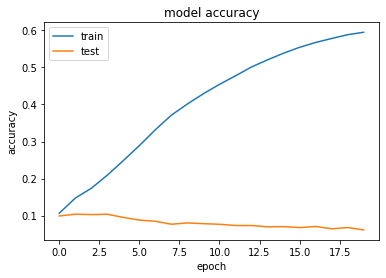

In [14]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

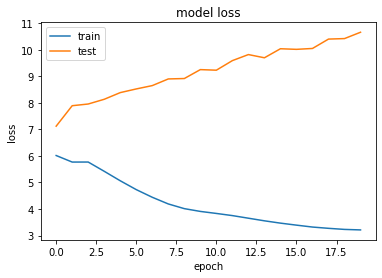

In [15]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [17]:
def prepare_input(text):
    x = np.zeros((1, Word_len, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [18]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [19]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [20]:
q =  "Your life will never be there in the same situation again"
print("correct sentence: ",q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

correct sentence:  Your life will never be there in the same situation again
Sequence:  your life will never be
your
life
will
never
be
next possible words:  ['so', 'of', 'very', 'room', 'wife']
